In [1]:
import pandas as pd
from xgboost import XGBRegressor
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
import time


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Import Functionality

In [2]:
from utils import (get_data,train_and_tune_xgboost_regressor,save_model,
                   load_model,assign_treatment,save_optimal_treatment_as_json,
                   dictionry_to_class, plot_feature_importance,plot_correlation_top_features)
from sklearn.metrics import mean_squared_error

## Set configs


In [3]:
#Define the configurations as a dictionary (*for further research, it is preferable to move it into a separate file out of the code).

configs_dict = dict(train_data_path = "data/train_home_assignment_.csv",
                   target_col = "org_price_usd_following_30_days",
                   columns_to_drop = ["treatment", "org_price_usd_following_30_days_after_impact"],
                   models_directory = "models",
                   model_name = "xbg_regressor_model_task1",
                   time_format = "%Y_%m_%d-%H_%M_%S",
                   model_file_type = "json",
                   model_path = "models/xbg_regressor_model_2023_04_14-09_00_07.json",
                   treatment_col_name = "treatment",
                   new_treatment_col_name = "optimal_treatment",
                   data_directory = "data",
                   test_size = 0.2,
                   treatment_values = [2,10])

# Convert dictionary into class 
configs = dictionry_to_class(configs_dict)

# Get data 

In [4]:
# Load data, remove unnecessary columns, split to train test 
X_train, X_test, y_train, y_test = get_data(path = configs.train_data_path, 
                                            target_col = configs.target_col, 
                                            test_size = configs.test_size,
                                            columns_to_drop = configs.columns_to_drop)

## Transormation, training and tuning

In [5]:
# Run data trasformation, grid search and cross validation
grid_search = train_and_tune_xgboost_regressor(X_train = X_train.head(50),
                                               y_train= y_train.head(50),
                                               numeric_cols = X_train.columns, 
                                               verbose = 2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__subsample=0.7; total time=   0.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__subsample=0.7; total time=   0.0s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__subsample=0.7; total time=   0.0s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.05, regressor__max_depth=3, regressor__min_child_weight=1, regressor__n_estimators=100, regressor__objective=reg:squarederror, regressor__subsample=0

### Save and load model

In [6]:
# Save model as json
save_model(model = grid_search,
           directory = configs.models_directory,
           name = configs.model_name,
           time_format = configs.time_format,
           file_type = configs.model_file_type)

'models/xbg_regressor_model_task1_2023_04_14-21_21_09.json'

In [7]:
# Load model
xgb_regressor = load_model(model_path = configs.model_path)

# Evaluate 

RMSE on train 

In [8]:
y_train_pred = xgb_regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
mse

5639.201670965522

RMSE on test 

In [9]:
y_test_pred = xgb_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
mse

5384.909140693616

# Summary

The README.md file will provide a discussion of the following results:

#### Feature importance 

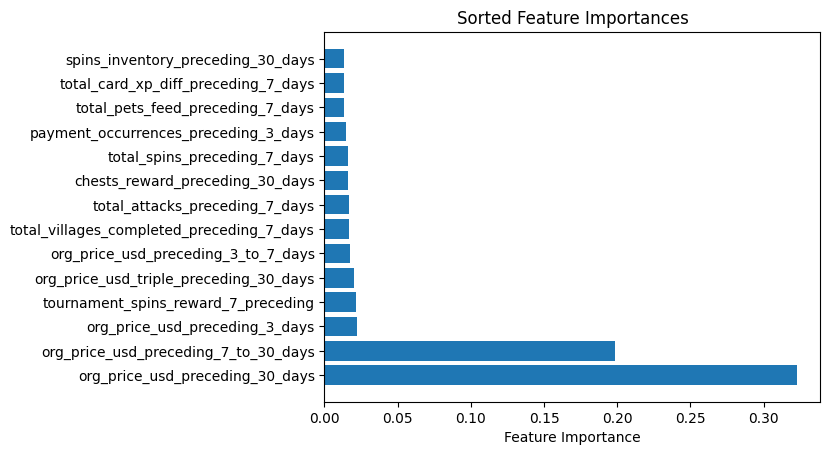

In [10]:
feature_importances=xgb_regressor.best_estimator_.named_steps['regressor'].feature_importances_
feature_names = X_train.columns
plot_feature_importance(feature_importances = feature_importances,
                        feature_names = feature_names)

Before picking the top 3 features, lets take alook over the correlations of theses features 

In [11]:
from IPython.display import clear_output


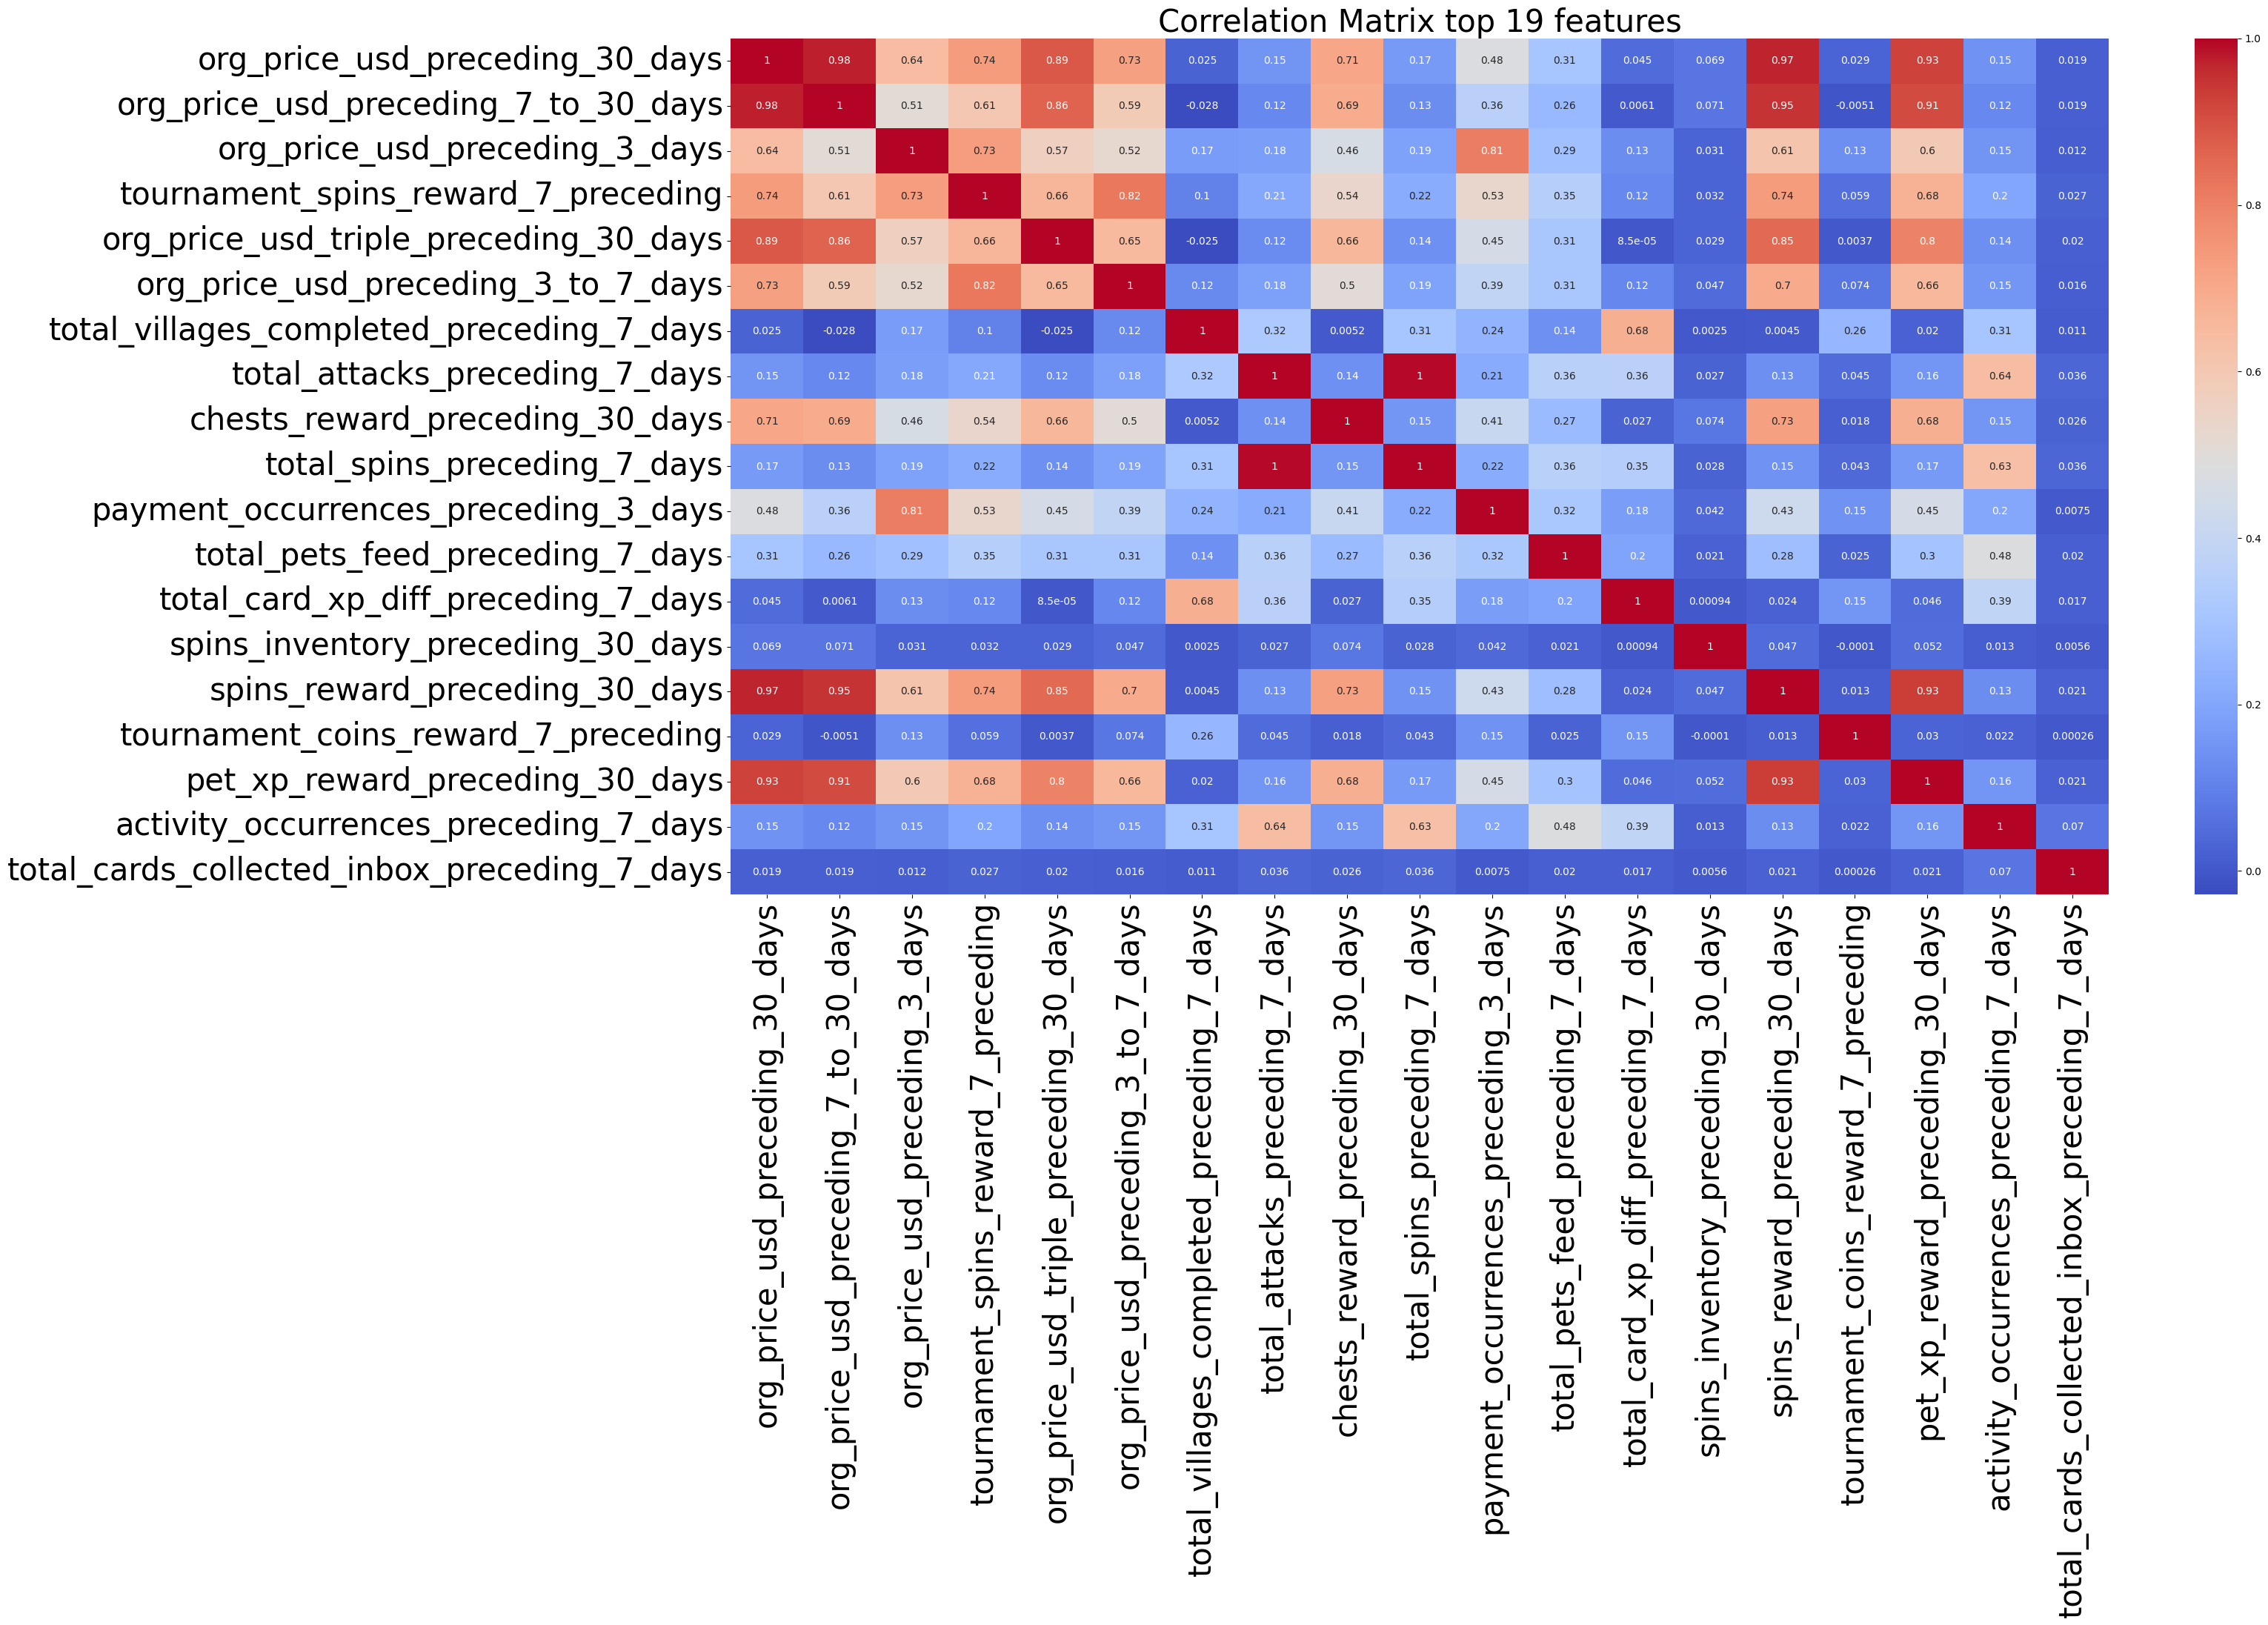

In [12]:
for i in range(2,20):
    plot_correlation_top_features(df = X_train,top_n = i , 
                                  feature_importances=feature_importances, 
                                  feature_names = feature_names)
    clear_output(wait=True)

In [21]:
y_col = configs.target_col

In [24]:
# X_train.columns

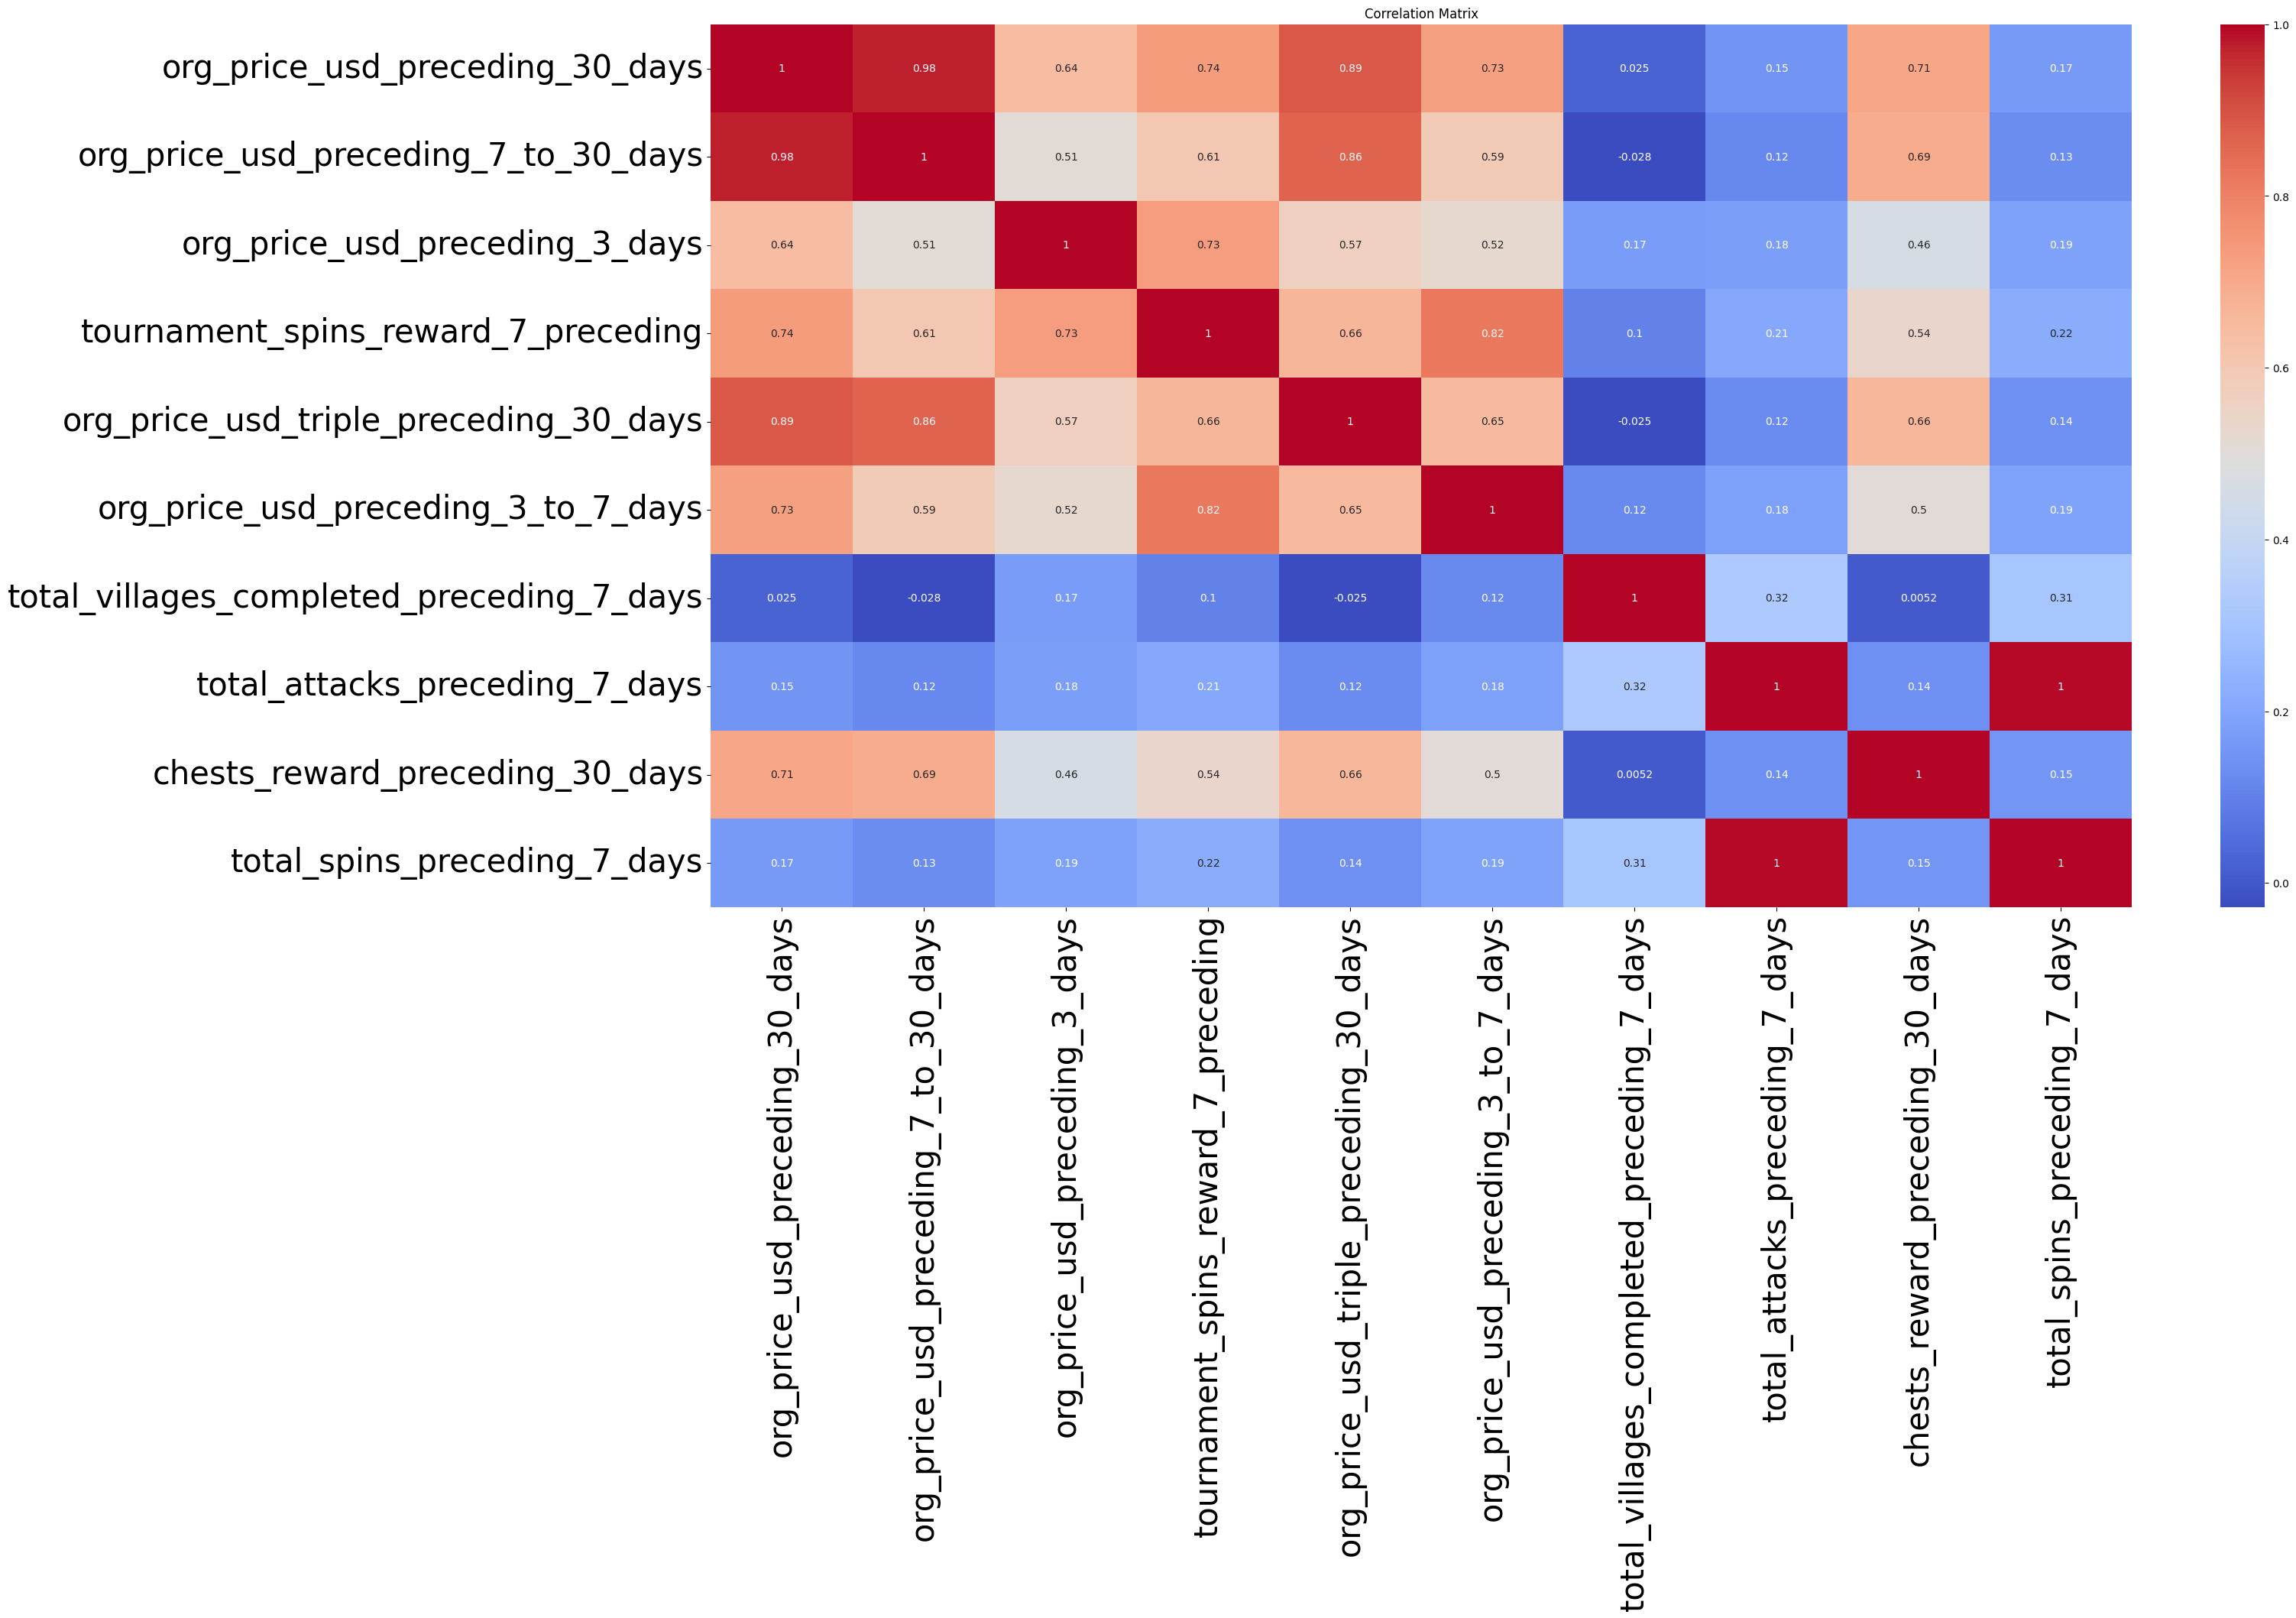

In [ ]:
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns




Even the highest feature importance is among the foolwing features 

1. `org_price_usd_preceding_30_days`
2. `org_price_usd_preceding_7_to_30_days`
3. `org_price_usd_preceding_3_dayss`

feautrs 1 and 2 suffer from high correlation (0.98) 

/Users/razisamuely/PycharmProjects/MoonActive/moonactive_venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


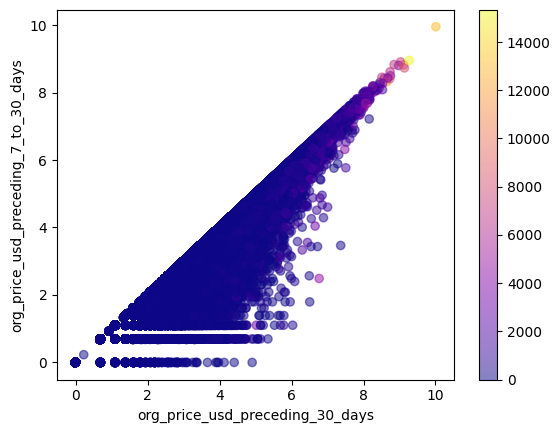

In [141]:
# get feature importances
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

# sort feature importances in descending order
indices = importances.argsort()[::-1]
 
# get the names of the top 3 most important features
feature_names = pd.DataFrame(X_train.columns)
top_features = feature_names.iloc[indices[:], 0].tolist()

# plot the data with respect to the top 3 features
f, ax = plt.subplots()
points = ax.scatter(np.log(X_train[top_features[0]]), 
                    np.log(X_train[top_features[1]]),
                    c = y_train.round().iloc[:,0].tolist(),
                    cmap="plasma",
                    alpha=0.5)

f.colorbar(points)

plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.show()



so we can give up 2 and choos 4 instead.

So the final top 3 features are which as low correlation:
1. `org_price_usd_preceding_30_days`
2. `org_price_usd_preceding_3_days`
3. `tournament_spins_reward_7_preceding`

In [185]:
df_train[df_train.org_price_usd_preceding_30_days!= \
         df_train.org_price_usd_preceding_3_days].\
         org_price_usd_following_30_days.nlargest(10)

166450    15330.08
26550     13223.17
101896    12055.63
152827     8363.33
142850     8117.89
177657     8089.69
817        7984.48
20230      7463.88
147645     7452.08
46008      7272.07
Name: org_price_usd_following_30_days, dtype: float64

/Users/razisamuely/PycharmProjects/MoonActive/moonactive_venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


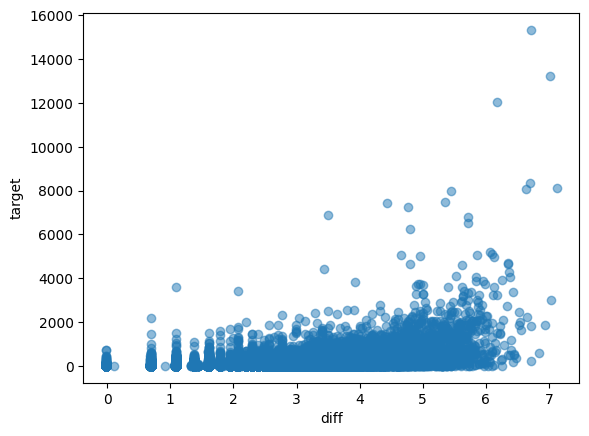

In [236]:
# plot the data with respect to the top 3 features
f, ax = plt.subplots()
points = ax.scatter(np.log(df_train.org_price_usd_preceding_3_days), 
                    df_train.org_price_usd_following_30_days,
                    alpha=0.5)


plt.xlabel("diff")
plt.ylabel("target")
plt.show()



### Summary 

In case we beleive the excpetional points are very reaer and not exit in a futur data i would choos : 

in case not i would choos : 

### Finde related features 

In [120]:
pd.set_option('display.max_rows', None)

In [131]:
# group by the two columns and count the occurrences
counts = df_train.groupby([top_features[0],
                           top_features[1],
                           top_features[2],
                           y_col
                         ]).size().reset_index(name='count')

# sort the result by the count in descending order
result = counts.sort_values(by=['count'], ascending=False)

result.head(10)

,org_price_usd_preceding_30_days,org_price_usd_preceding_7_to_30_days,org_price_usd_preceding_3_days,org_price_usd_following_30_days,count
732,1.99,1.99,0.00,0.0,8945
1941,2.99,2.99,0.00,0.0,7270
4247,4.99,4.99,0.00,0.0,4850
3044,3.99,3.99,0.00,0.0,4428
1309,2.99,0.00,0.00,0.0,2197
1570,2.99,0.00,2.99,0.0,2007
5717,5.99,5.99,0.00,0.0,1959
8287,7.98,7.98,0.00,0.0,1893
8852,7.99,7.99,0.00,0.0,1720
6661,6.98,6.98,0.00,0.0,1697


In [132]:
result =  result[result[top_features[0]].isin(result[top_features[0]].head(2)) &\
                 result[top_features[1]].isin(result[top_features[1]].head(2)) &\
                 result[top_features[2]].isin(result[top_features[2]].head(2)) ]
result

,org_price_usd_preceding_30_days,org_price_usd_preceding_7_to_30_days,org_price_usd_preceding_3_days,org_price_usd_following_30_days,count
732,1.99,1.99,0.0,0.00,8945
1941,2.99,2.99,0.0,0.00,7270
1945,2.99,2.99,0.0,2.99,1108
737,1.99,1.99,0.0,2.99,967
1953,2.99,2.99,0.0,5.98,298
744,1.99,1.99,0.0,5.98,263
1960,2.99,2.99,0.0,7.98,250
1951,2.99,2.99,0.0,4.99,249
1947,2.99,2.99,0.0,3.99,241
740,1.99,1.99,0.0,3.99,215


In [133]:
# group by the two columns and count the occurrences
result = result.groupby([top_features[0],
                         top_features[1],
                         top_features[2],
                         ]).size().reset_index(name='count')


result = result.sort_values(by=['count'], ascending=True)

result.head(1000)

,org_price_usd_preceding_30_days,org_price_usd_preceding_7_to_30_days,org_price_usd_preceding_3_days,count
0,1.99,1.99,0.0,339
1,2.99,2.99,0.0,392


In [108]:
feature_names.iloc[indices[:3], 0].tolist()

['org_price_usd_preceding_30_days',
 'org_price_usd_preceding_7_to_30_days',
 'org_price_usd_preceding_3_days',
 'tournament_spins_reward_7_preceding',
 'org_price_usd_triple_preceding_30_days',
 'org_price_usd_preceding_3_to_7_days',
 'total_villages_completed_preceding_7_days',
 'total_attacks_preceding_7_days',
 'chests_reward_preceding_30_days',
 'total_spins_preceding_7_days']

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from xgboost import XGBRegressor


# # Create preprocessing pipeline
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features)])

# # Create XGBRegressor pipeline
# xgb_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('imputer', SimpleImputer(strategy='median')),
#     ('xgb', XGBRegressor())])

# # Define hyperparameters to search over
# param_grid = {
#     'xgb__learning_rate': [0.05, 0.1, 0.15],
#     'xgb__max_depth': [3, 5, 7],
#     'xgb__min_child_weight': [1, 3, 5],
#     'xgb__subsample': [0.7, 0.8, 0.9],
#     'xgb__colsample_bytree': [0.7, 0.8, 0.9],
#     'xgb__n_estimators': [100, 200, 300],
#     'xgb__objective': ['reg:squarederror']
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, n_jobs=-1)

# # Fit GridSearchCV object to data
# grid_search.fit(X_train, y_train)

# # Evaluate performance using cross-validation
# scores = cross_val_score(grid_search, X_test, y_test, cv=5, scoring='r2')
# print('R-squared scores: ', scores)



# PCA T-SNEE

In [173]:
feature_importance = grid_search.best_estimator_.named_steps['regressor'].feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
feature_names = X_train.columns
sorted_idx

array([41, 36,  3, 17, 43, 48,  6, 42,  8, 15, 27, 19, 16, 47, 50, 34, 12,
       45, 38, 14, 51, 25, 22, 18, 46,  1, 35, 32, 11,  2, 33, 39, 26, 31,
       13, 37, 24, 28, 44,  7, 29, 21,  4, 40,  9, 52,  5,  0, 10, 20, 30,
       23, 49])

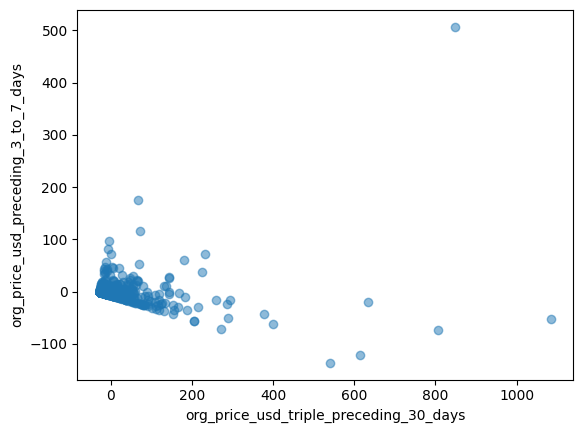

In [187]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# define the pipeline
pipe = Pipeline([
    ('pca', PCA(n_components=2)),   # reduce dimensions using PCA
#     ('tsne', TSNE(n_components=2))  # further reduce dimensions using t-SNE
])

# fit the pipeline to your data
featurs_i = [43, 48]
top_10_features = [feature_names[i] for i in featurs_i]
df_top = X_train[top_10_features].head(1000)

pipe.fit(df_top)

# transform the data to the reduced dimensions
X_reduced = pipe.fit_transform(df_top)

# plot the data with respect to the most significant 3 features
fig = plt.figure()
# ax = fig.add_subplot(projection='2d')

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.xlabel(top_10_features[0])
plt.ylabel(top_10_features[1])
plt.show()

# Feature importance correlations 

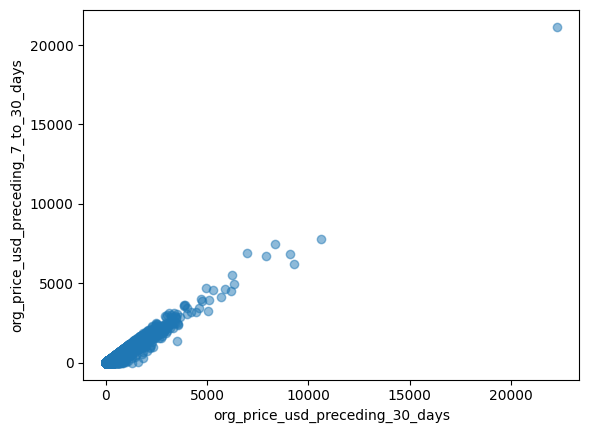

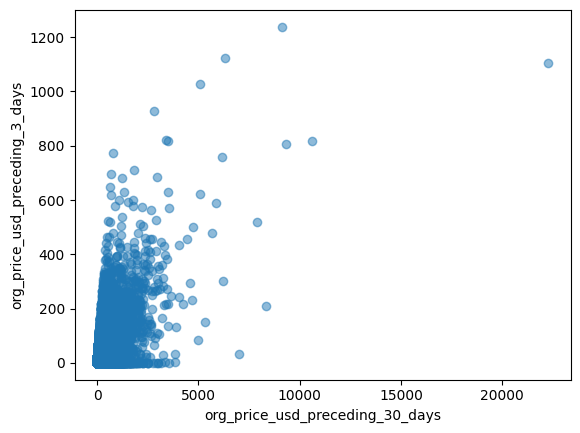

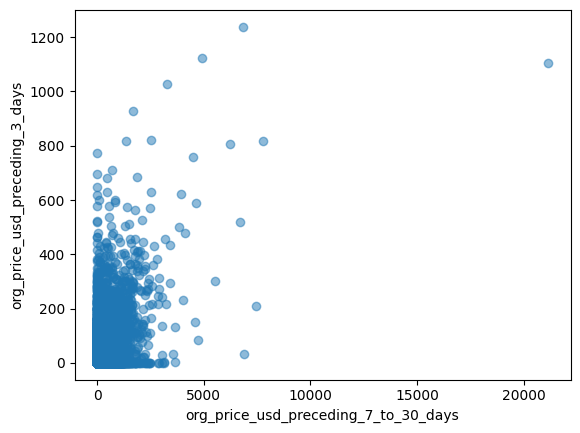

In [105]:

# get feature importances
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

# sort feature importances in descending order
indices = importances.argsort()[::-1]

# get the names of the top 3 most important features
feature_names = pd.DataFrame(X_train.columns)
top_3_features = feature_names.iloc[indices[:3], 0].tolist()

# plot the data with respect to the top 3 features
plt.scatter(X_train[top_3_features[0]], X_train[top_3_features[1]], alpha=0.5)
plt.xlabel(top_3_features[0])
plt.ylabel(top_3_features[1])
plt.show()

plt.scatter(X_train[top_3_features[0]], X_train[top_3_features[2]], alpha=0.5)
plt.xlabel(top_3_features[0])
plt.ylabel(top_3_features[2])
plt.show()

plt.scatter(X_train[top_3_features[1]], X_train[top_3_features[2]], alpha=0.5)
plt.xlabel(top_3_features[1])
plt.ylabel(top_3_features[2])
plt.show()




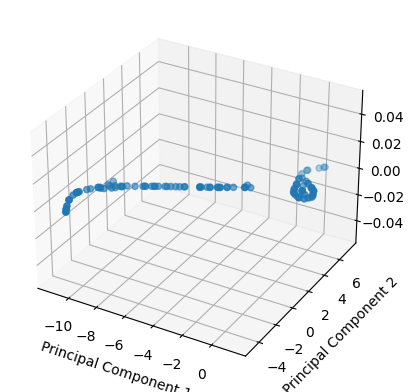

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# define the pipeline
pipe = Pipeline([
    ('pca', PCA(n_components=2)),   # reduce dimensions using PCA
    ('tsne', TSNE(n_components=2))  # further reduce dimensions using t-SNE
])

# fit the pipeline to your data
top_10_features = feature_names.iloc[indices[:5], 0].tolist()
df_top = X_train[top_10_features].head(100)

pipe.fit(df_top)

# transform the data to the reduced dimensions
X_reduced = pipe.fit_transform(df_top)

# plot the data with respect to the most significant 3 features
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.show()

# Correlation plot with herachical clustering 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(corr, 
                   method = 'complete', 
                   cmap   = 'RdBu', 
                   annot  = True, 
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=70);

### Log shows many unchaged values between two columns 

In [ ]:
# get feature importances
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

# sort feature importances in descending order
indices = importances.argsort()[::-1]

# get the names of the top 3 most important features
feature_names = pd.DataFrame(X_train.columns)
top_3_features = feature_names.iloc[indices[:], 0].tolist()

# plot the data with respect to the top 3 features
plt.scatter(np.log(X_train[top_3_features[3]]), 
            np.log(X_train[top_3_features[4]]), 
            
            alpha=0.5)
plt.xlabel(top_3_features[0])
plt.ylabel(top_3_features[1])
plt.show()


In [ ]:

# Define the preprocessing steps for numerical  features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Define the column transformer to apply the appropriate preprocessing steps to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)])

# Define the full pipeline by chaining together the preprocessor and XGBRegressor
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor())])

# Define the parameter grid to search over
param_grid = {'regressor__learning_rate': [0.1, 0.5],
              'regressor__max_depth': [3, 6],
              'regressor__n_estimators': [50, 100]}

# Define the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

